In [91]:
# hide
%reload_ext autoreload
%autoreload 2

In [92]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from dataFunction import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *
import seaborn as sns
from sklearn.linear_model import LinearRegression

random.seed(11007303)
np.random.seed(2021)

In [101]:
cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)

df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }

In [103]:
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    # cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    # location_data = make_dummies(location_data, cat_feat)
    x = location_data
    glob_model = LR(len(x.columns))
    # print(ty pe(y))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss()))



In [83]:
clients[0].X

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.947160,1.0,1.0,0.756274,1.0,2.0,0.017169,0.0,1.085542,3.0
1,1.389703,1.0,4.0,1.608559,0.0,2.0,-1.818896,1.0,0.396526,2.0
2,1.389703,1.0,4.0,-0.664201,0.0,2.0,-0.900864,1.0,1.343924,2.0
3,-1.929372,1.0,3.0,-0.096011,0.0,0.0,1.634655,0.0,2.119067,3.0
4,-1.486829,0.0,2.0,-0.096011,0.0,2.0,0.978917,0.0,0.310399,1.0
...,...,...,...,...,...,...,...,...,...,...
298,-1.044285,1.0,1.0,-1.232391,0.0,0.0,-0.769716,0.0,0.138144,2.0
299,1.500339,1.0,4.0,0.699455,1.0,0.0,-0.376274,0.0,2.032940,2.0
300,0.283345,1.0,4.0,-0.096011,0.0,0.0,-1.512885,1.0,0.138144,2.0
301,0.283345,0.0,2.0,-0.096011,0.0,2.0,1.066349,0.0,-0.895381,2.0


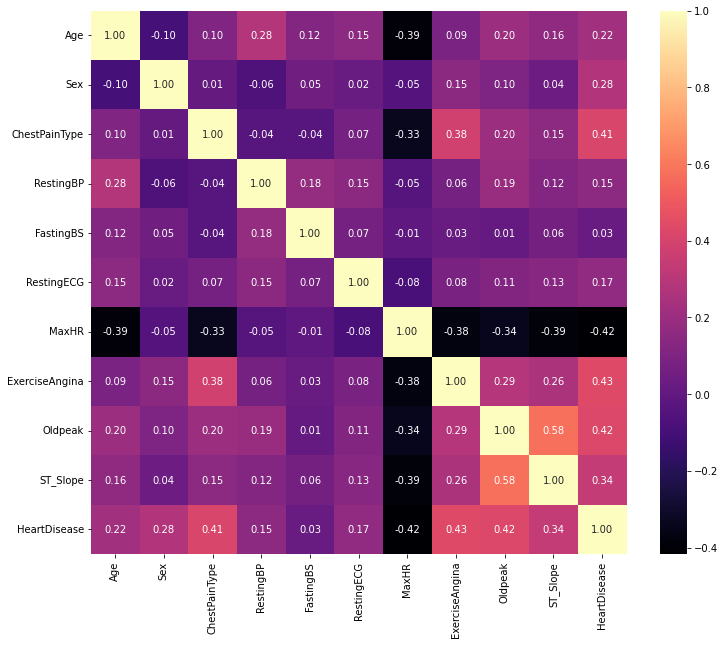

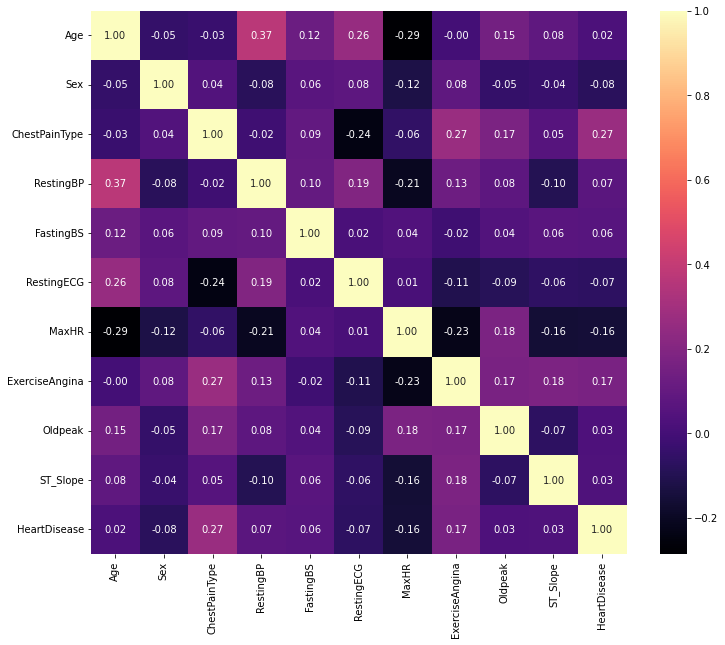

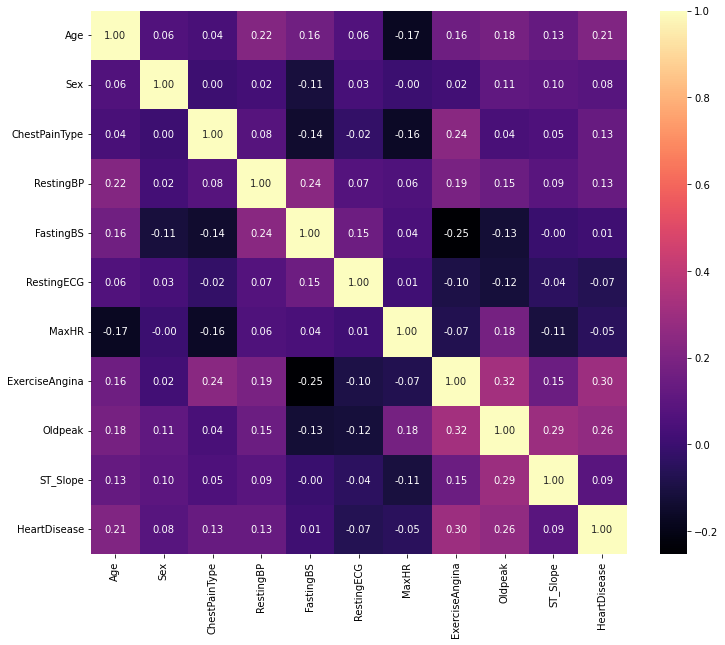

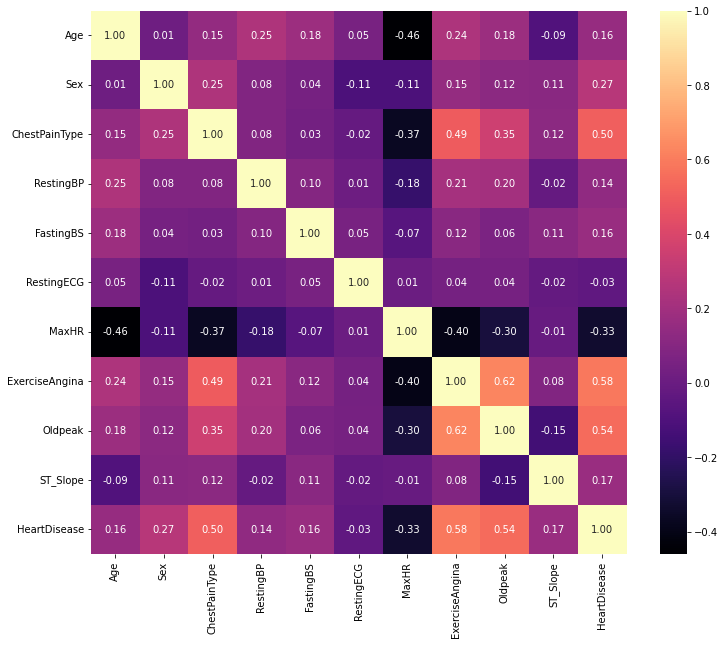

In [17]:
for i in clients:
    # print(i.X.Oldpeak)
    xy = pd.concat([i.X, i.y], axis=1)
    plt.figure(figsize=(12,10))
    sns.heatmap(xy.corr(),annot=True,cmap="magma",fmt='.2f')
    # print(xy)

In [25]:
clients[2].X.describe()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
count,1.460000e+02,146.000000,146.000000,1.460000e+02,146.000000,146.000000,1.460000e+02,146.000000,1.460000e+02,146.000000
mean,2.615868e-16,0.965753,3.616438,7.003530e-16,0.321918,0.719178,-2.129195e-16,0.643836,3.650048e-17,2.089041
std,1.000000e+00,0.182488,0.716892,1.000000e+00,0.468820,0.692254,1.000000e+00,0.480513,1.000000e+00,0.549874
min,-2.832702e+00,0.000000,1.000000,-2.110593e+00,0.000000,0.000000,-2.439841e+00,0.000000,-1.677059e+00,1.000000
25%,-5.484612e-01,1.000000,3.000000,-7.662926e-01,0.000000,0.000000,-6.494653e-01,0.000000,-1.219736e+00,2.000000
50%,8.605017e-02,1.000000,4.000000,-2.450332e-01,0.000000,1.000000,-1.282166e-01,1.000000,1.522321e-01,2.000000
75%,4.667570e-01,1.000000,4.000000,5.231385e-01,1.000000,1.000000,7.783028e-01,1.000000,6.095547e-01,2.000000
max,2.243389e+00,1.000000,4.000000,3.047131e+00,1.000000,2.000000,2.591342e+00,1.000000,2.438845e+00,3.000000


In [19]:
client1_mean = clients[0].X.mean()
client2_mean = clients[2].X.mean()

In [20]:
client1_cov = clients[0].X.cov()
client2_cov = clients[2].X.cov()

In [68]:
def KL_divergence_multi(client1, client2):
    mu1 = client1.X.mean()
    cov1 = client1.X.cov()

    mu2 = client2.X.mean()
    cov2 = client2.X.cov()

    mu_dif = mu2 - mu1
    inv_cov2 = np.linalg.inv(cov2)
    trace_cov12 = np.trace((inv_cov2 @ cov1).to_numpy())
    det_cov1 = np.linalg.det(cov1)
    det_cov2 = np.linalg.det(cov2)

    return 1/2 *( mu_dif.T @ inv_cov2 @ mu_dif+trace_cov12-np.log(det_cov1/det_cov2)-len(mu1))

In [69]:
def KL_divergence_norm(dist1, dist2):
    mu1 = dist1[0]
    cov1 = dist1[1]

    mu2 = dist2[0]
    cov2 = dist2[1]

    return 1/2 *( (mu2-mu1)**2/cov2+cov1/cov2-np.log(cov1/cov2)-1)


In [70]:
def KL_divergence_disc(prop1, prop2):
        return sum(prop1*np.log(prop1/prop2))    


In [71]:
def prob_discrete_var(outcomes):
    val, cnt = np.unique(outcomes, return_counts=True)
    prop = cnt / len(outcomes)
    return prop

In [72]:
prob_discrete_var(clients[0].X.ChestPainType)

array([0.07590759, 0.1650165 , 0.28382838, 0.47524752])

In [73]:
KL_divergence_disc(prob_discrete_var(clients[0].X.ChestPainType),prob_discrete_var(clients[1].X.ChestPainType))

0.16915710015134028

In [100]:
kl = np.empty((len(clients), len(clients)))
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']

for i in range(len(clients)):
    for j in range(len(clients)):  
        kl_all_cat = [] 
        for c in cat_feat:
            kl_all_cat.append(KL_divergence_disc(prob_discrete_var(clients[i].X[c]),prob_discrete_var(clients[j].X[c])))
        # print(kl_all_cat)
        kl[i,j] = sum(kl_all_cat) + KL_divergence_multi(clients[i], clients[j])
print('KL with Switzerland without Cholesterol')
print(kl)

KL with Switzerland without Cholesterol
[[ 0.          5.24427999  6.489122   11.31361114]
 [ 3.27343395  0.          2.1807392   5.69259586]
 [ 4.17561838  3.84743159  0.          7.84133871]
 [ 3.71040674  3.66417697  6.58452399  0.        ]]


In [104]:
kl = np.empty((len(clients), len(clients)))
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']

for i in range(len(clients)):
    for j in range(len(clients)):  
        kl_all_cat = [] 
        for c in cat_feat:
            kl_all_cat.append(KL_divergence_disc(prob_discrete_var(clients[i].X[c]),prob_discrete_var(clients[j].X[c])))
        # print(kl_all_cat)
        kl[i,j] = sum(kl_all_cat) + KL_divergence_multi(clients[i], clients[j])
print('KL without Switzerland with Cholesterol')
print(kl)

KL without Switzerland with Cholesterol
[[0.00000000e+00 6.56804828e+00 1.13778624e+01]
 [4.24035327e+00 8.88178420e-16 7.89178268e+00]
 [3.77528458e+00 6.68555924e+00 0.00000000e+00]]


In [14]:
eigval, eigvec = np.linalg.eig(clients[2].X.cov())
print(eigval)
print( np.linalg.det(clients[2].X.cov()))

[ 1.44170166e+00  1.18770465e+00  9.49300705e-01  6.90984785e-01
  3.83720135e-01  3.05789398e-01  2.58320817e-01  2.30621706e-01
  1.69075249e-01  1.36294016e-01  1.19146178e-01  7.06491381e-02
  2.97978101e-02  3.20897882e-02  2.33236372e-16 -9.04502709e-17
  6.92905737e-17]
-1.4236158445223535e-57


In [34]:
kl_cont = np.empty((len(clients), len(clients)))
for i in range(len(clients)):
    for j in range(len(clients)):                   
        kl_cont[i,j] = KL_divergence(clients[i], clients[j])
print(kl_cont)

[[0.         5.92011479 9.02918111]
 [4.77337268 0.         8.05348176]
 [2.40224387 6.1181905  0.        ]]


In [ ]:
# Plot predicted vs test!

import plotly.graph_objects as go
 
fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))